In [2]:
import arch
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
from scipy.stats import t
from scipy.stats import genextreme as gev

In [72]:
df = pd.read_csv("/Users/quinnhollister/Downloads/intel_d_logret.txt", delim_whitespace = True, header = None,
           parse_dates = True)
df.rename(columns = {0: "Date", 1: "logret"}, inplace = True)
df['logret_MA_10'] = df.logret.rolling(10).sum() 
df.head(100)

,Date,logret,logret_MA_10
0,7/10/1986,-0.024692,NaN
1,7/11/1986,-0.105360,NaN
2,7/14/1986,0.000000,NaN
3,7/15/1986,0.000000,NaN
4,7/16/1986,-0.028171,NaN
...,...,...,...
95,11/21/1986,0.025318,1.734723e-17
96,11/24/1986,0.024692,2.469245e-02
97,11/25/1986,0.024097,7.410748e-02
98,11/26/1986,0.023530,1.236131e-01


In [69]:
#I calculated the VaR estimates using R with the rugarch package, and then created a df that contained the VaR
#estimates for each observation in our sample. We can use the mean's to compute a rough estimate for our question

VaR = pd.read_csv("VaR.csv")
VaR.head()

,VaR..,VaR10.
0,0.069782,0.326114
1,0.069271,0.322041
2,0.082848,0.380129
3,0.081597,0.375634
4,0.080323,0.370761


For part c, lets model the log returns as an ARMA(1,1)-GARCH(1,1) process with the residuals coming from the student t-distribution. So, our model looks like: 

$$r_{t} = \phi_{0} + \phi_{1} \cdot r_{t-1} + u_{t} + \psi_{1} \cdot u_{t-1} $$


$$\sigma_{t}^{2} = \omega + \alpha_{1} \cdot u_{t-1}^{2} + \beta_{1} \cdot \sigma_{t-1}^{2} $$

where $u_{t} = \sigma_{t} \epsilon_{t} $ and $\epsilon_{t} \sim t_{v}$
Thus, the ARMA process models the conditional mean, and the GARCH process models the conditional variance present in the resdiuals of the ARMA estimation. Note: ARMA estimates are generally inconsistent, so this approach may contaminate the GARCH estimates. 

In [70]:
VaR1 = sum(VaR["VaR.."])/len(VaR["VaR.."])
VaR10 = sum(VaR["VaR10."])/len(VaR["VaR10."])

PORTFOLIO = 10**6
print("99% VaR for One-Day Return:  $" + str(round(VaR1*PORTFOLIO, 2)))
print("99% VaR for Ten-Day Return:  $" + str(round(VaR10*PORTFOLIO, 2)))

99% VaR for One-Day Return:  $65690.44
99% VaR for Ten-Day Return:  $306544.07


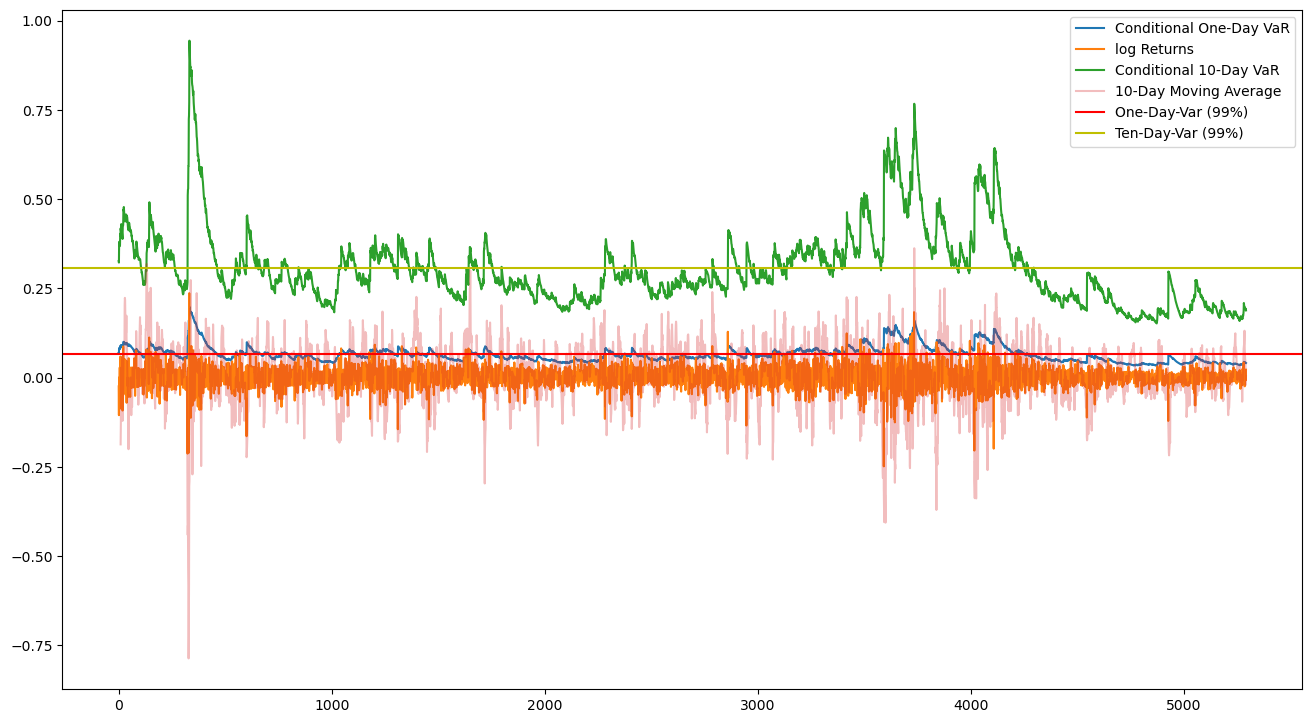

In [73]:
fig, axes = plt.subplots(1, 1, figsize=(16, 9), dpi=100)

axes.plot(VaR["VaR.."], label = "Conditional One-Day VaR")
axes.plot(df["logret"], label = "log Returns")
axes.plot(VaR["VaR10."], label = "Conditional 10-Day VaR")
axes.plot(df["logret_MA_10"], alpha = 0.3, label = "10-Day Moving Average")
axes.axhline(y = VaR1, color = 'r', linestyle = '-', label = "One-Day-Var (99%)")
axes.axhline(y = VaR10, color = 'y', linestyle = '-', label = "Ten-Day-Var (99%)")
plt.legend()

Now, we'll recalculate these VAR quanities but instead using the GEV distribution with a subperiod length of 20 trading days. 

In [58]:
#First, let's split our data into subsamples with width of 20 days, and selecting the 
#minimum values from these samples
PER_LENGTH = 20
PERIODS = int(len(df)/PER_LENGTH)

subperiod = []
for i in range(0, PERIODS):
    sub = df['logret'].iloc[i*20: (i+1)*20]
    sub = sub*(-1)
    subperiod.append(sub.values.max())
    
#We possibly didn't include some of the values at the end of our data
if len(df) % PER_LENGTH != 0:
    lastPer = df['logret'].iloc[PER_LENGTH*PERIODS: -1]
    lastPer = lastPer*(-1)
    subperiod.append(lastPer.values.max())


Minimum Value in Whole Data: 0.012237368
Shape: -0.2795790757252311
Loc: 0.03452280396821579
Scale: 0.016690903232581475


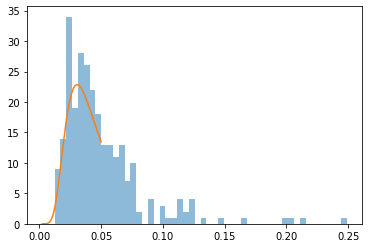

In [52]:
#now lets fit this data to a GEV distribution
plt.hist(subperiod, bins = 50, alpha = 0.5)

print("Minimum Value in Whole Data: " + str(min(subperiod)))

#need to specify good inital location, otherwise might be zero and that leads to bad fit.
params = gev.fit(subperiod)


print("Shape: " + str(params[0]))
print("Loc: " + str(params[1]))
print("Scale: " + str(params[2]))



shape = params[0]
loc = params[1]
scale = params[2]

xx = np.linspace(min(subperiod)-0.01, 0.05, 500)
plt.plot(xx, gev.pdf(xx, *params))

In [53]:
ALPHA = 0.01
percentile = (1-ALPHA)**20
gevOneVar = gev.ppf(percentile, shape, scale = scale, loc = loc)
print("99% one day VAR for a portfolio of $1 Million with GEV:  $" + str(round(abs(gevOneVar)*1000000, 2)))

99% one day VAR for a portfolio of $1 Million with GEV:  $68316.51


In [61]:
#First, let's sum our data and bucket into 10 day returns, then we'll take 20 samples and take min's. 
TenDayVarDF = df.groupby(df.index // 10).sum()




PER_LENGTH = 20
TEN_PERIODS = int(len(TenDayVarDF)/PER_LENGTH)

tenDaySubPeriod = []
for i in range(0, TEN_PERIODS):
    sub = TenDayVarDF['logret'].iloc[i*20: (i+1)*20]
    sub = sub*(-1)
    tenDaySubPeriod.append(sub.values.max())
    
#We possibly didn't include some of the values at the end of our data
if len(TenDayVarDF) % PER_LENGTH != 0:
    lastPer = TenDayVarDF['logret'].iloc[PER_LENGTH*TEN_PERIODS: -1]
    lastPer = lastPer*(-1)
    tenDaySubPeriod.append(lastPer.values.max())

print(len(tenDaySubPeriod))

27


Minimum Value in Whole Data: 0.060065866
Shape: -0.27722575093767043
Loc: 0.12156628926942828
Scale: 0.05494659515413722


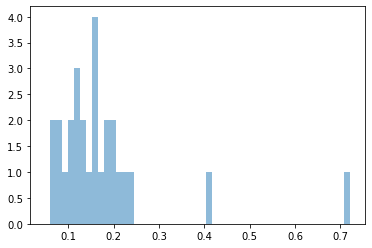

In [62]:
#now lets fit this data to a GEV distribution
plt.hist(tenDaySubPeriod, bins = 50, alpha = 0.5)

print("Minimum Value in Whole Data: " + str(min(tenDaySubPeriod)))

#need to specify good inital location, otherwise might be zero and that leads to bad fit.
tenParams = gev.fit(tenDaySubPeriod, loc = 0.01)


print("Shape: " + str(tenParams[0]))
print("Loc: " + str(tenParams[1]))
print("Scale: " + str(tenParams[2]))



tenShape = tenParams[0]
tenLoc = tenParams[1]
tenScale = tenParams[2]

xx = np.linspace(min(tenDaySubPeriod)-0.01, 0.05, 500)
plt.plot(xx, gev.pdf(xx, *tenParams))

In [64]:
ALPHA = 0.01
percentile = (1-ALPHA)**20
gevTenVar = gev.ppf(percentile, tenShape, scale = tenScale, loc = tenLoc)
print("99% ten day VAR for a portfolio of $1 Million with GEV:  $" + str(round(abs(gevTenVar)*1000000, 2)))

99% ten day VAR for a portfolio of $1 Million with GEV:  $232590.08


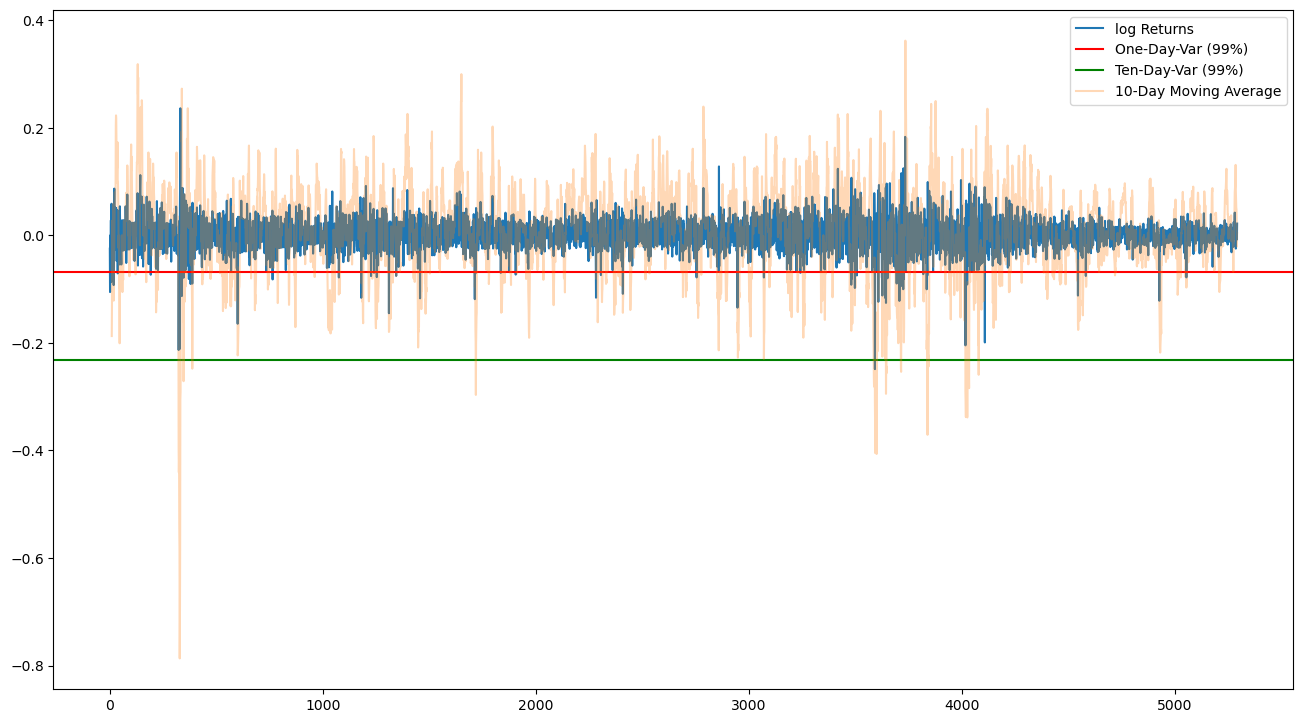

In [67]:
fig, axes = plt.subplots(1, 1, figsize=(16, 9), dpi=100)

axes.plot(df["logret"], label = "log Returns")
axes.axhline(y = -1*gevOneVar, color = 'r', linestyle = '-', label = "One-Day-Var (99%)")
axes.axhline(y = -1*gevTenVar, color = 'g', linestyle = '-', label = "Ten-Day-Var (99%)")
axes.plot(df["logret_MA_10"], alpha = 0.3, label = "10-Day Moving Average")

plt.legend()